In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time

df = pd.read_csv('WineQT.csv')
df.head()
df['target'] = (df['quality'] >= 7).astype(int)

In [6]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
 13  target                1143 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 125.1 KB


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
target                  0
dtype: int64

In [7]:

df.describe(include='all')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id,target
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379,0.139108
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116,0.346210
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000,0.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000,0.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000,1.000000


target
0    0.860892
1    0.139108
Name: proportion, dtype: float64


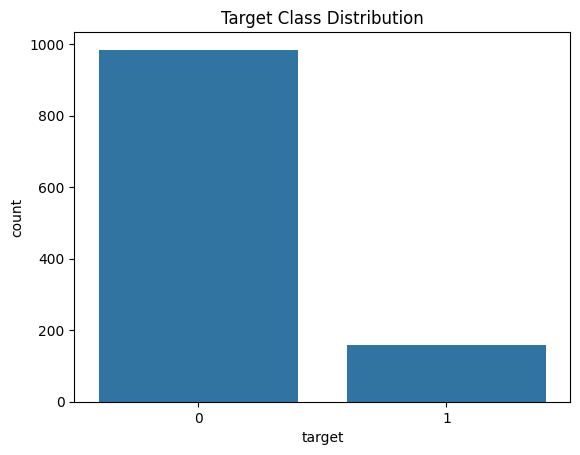

In [8]:

print(df['target'].value_counts(normalize=True))
sns.countplot(x='target', data=df)
plt.title('Target Class Distribution')
plt.show()

In [9]:

df.duplicated().sum()

np.int64(0)

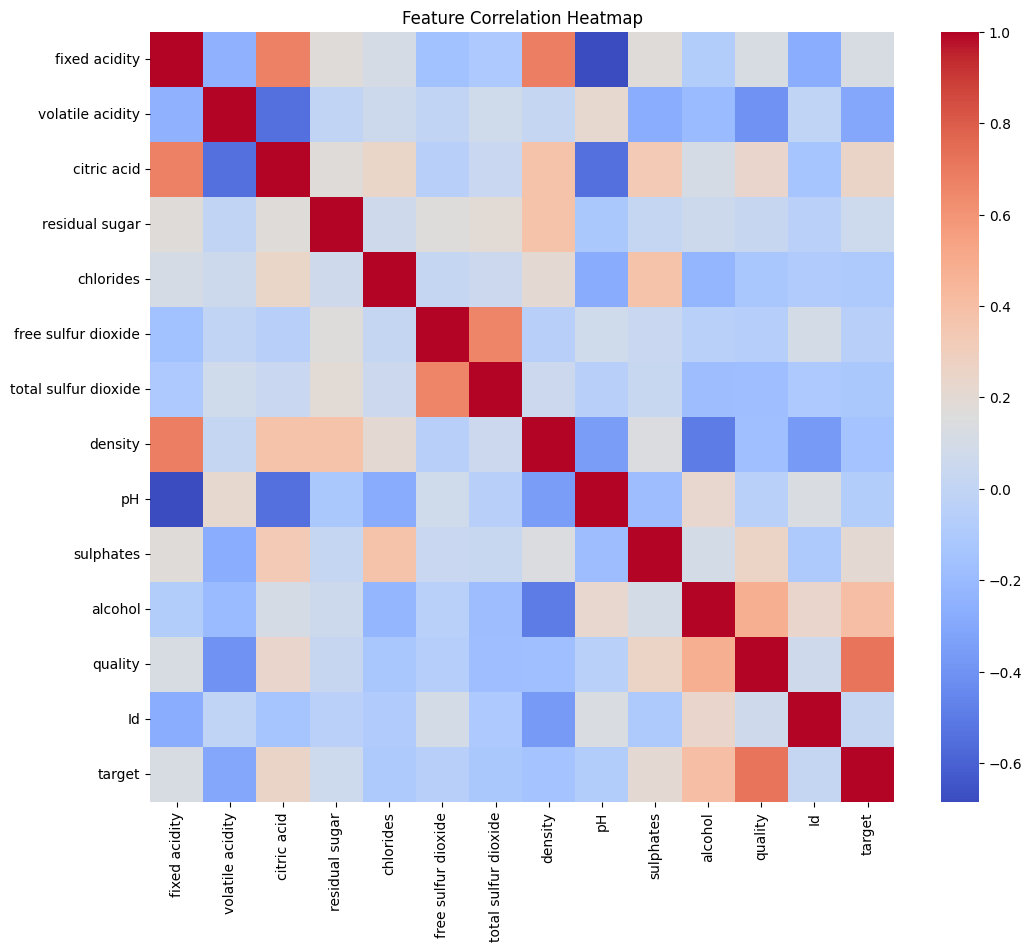

In [10]:

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [13]:
X = df.drop(['quality', 'target'], axis=1)
y = df['target']

numeric_cols = X.columns.tolist()
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, class_weight='balanced'), {'clf__C': [0.1]}),
    'Random Forest': (RandomForestClassifier(random_state=42), {'clf__n_estimators': [100], 'clf__max_depth': [None]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'clf__n_estimators': [100]}),
    'SVC': (SVC(probability=True, class_weight='balanced'), {'clf__C': [1]}),
    'KNN': (KNeighborsClassifier(), {'clf__n_neighbors': [5]})
}

results = []
for model_name, (model, param_grid) in models.items():
    print(f'Training: {model_name}')
    start = time.time()
    pipe = ImbPipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    grid = GridSearchCV(pipe, param_grid, cv=2, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]
    results.append((model_name, grid.best_params_, accuracy_score(y_test, y_pred),
                   precision_score(y_test, y_pred), recall_score(y_test, y_pred),
                   f1_score(y_test, y_pred), roc_auc_score(y_test, y_prob)))
    print(f'{model_name} took {time.time() - start:.2f} seconds')
    print()
pd.DataFrame(results, columns=['Model', 'Best Params', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

Training: Logistic Regression
Logistic Regression took 0.11 seconds

Training: Random Forest


/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Lib

Random Forest took 1.22 seconds

Training: Gradient Boosting


/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Gradient Boosting took 1.52 seconds

Training: SVC


/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


SVC took 0.57 seconds

Training: KNN
KNN took 0.18 seconds



/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/mounikasaka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


,Model,Best Params,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,{'clf__C': 0.1},0.803493,0.381818,0.65625,0.482759,0.852792
1,Random Forest,"{'clf__max_depth': None, 'clf__n_estimators': ...",0.890830,0.606061,0.62500,0.615385,0.911564
2,Gradient Boosting,{'clf__n_estimators': 100},0.864629,0.513514,0.59375,0.550725,0.864530
3,SVC,{'clf__C': 1},0.868996,0.522727,0.71875,0.605263,0.878331
4,KNN,{'clf__n_neighbors': 5},0.812227,0.412698,0.81250,0.547368,0.832249
